<a href="https://colab.research.google.com/github/ilmechaJu/dl_start_guide/blob/master/Mask_on_off_array.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#GPU 할당 받은 사양 보는 법
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7550712237854247271, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11344216064
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1173666303539350111
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

In [3]:
#데이터셋 파일 사전준비 (1)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#txt파일 만드는 법
with open('/content/drive/My Drive/mydata.txt','w') as f:
 f. write('Hello')

In [4]:
#txt 파일 cat으로 보기
!cat /content/drive/MyDrive/mydata.txt

Hello

In [5]:
#<텐서 버전확인>
import tensorflow as tf
tf.__version__

'2.5.0'

Found 37 images belonging to 2 classes.
Found 37 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


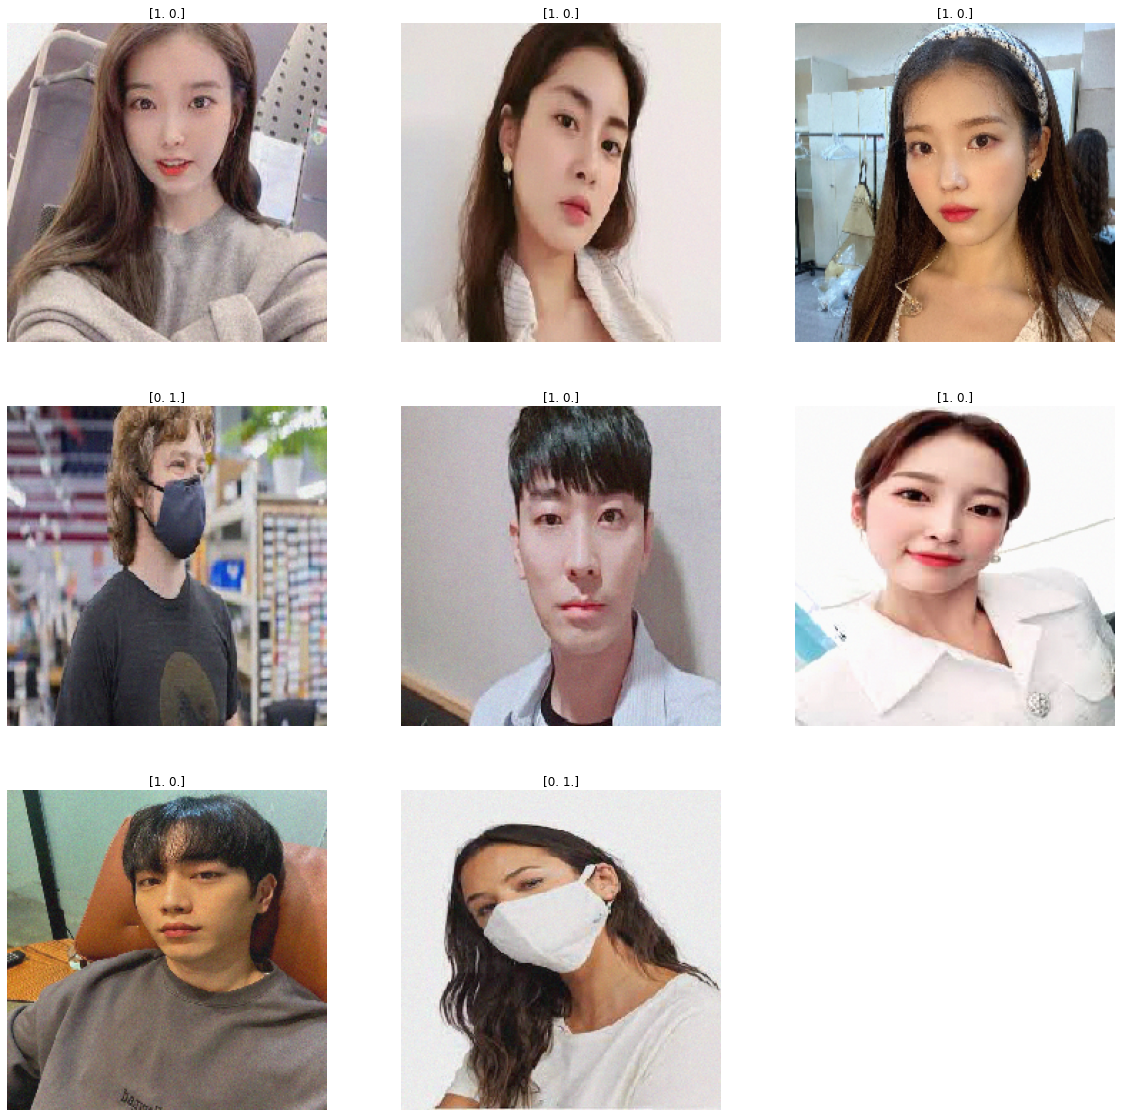

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [2]:
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
import numpy as np

import matplotlib.pyplot as plt


# Random Noise Function
def add_random_noise(x):
    x = x + np.random.normal(size=x.shape) * np.random.uniform(1, 5)
    x = x - x.min()
    x = x / x.max()

    return x * 255.0


# Set your dataset directory
# Directory Structure:
# -- train-set
# ------------/on_mask
# ------------/off_mask
# --- test-set
# ------------/on_mask
# ------------/off_mask

TRAINING_DIR = "/content/drive/MyDrive/mask_dataset" #경로 설정
VALIDATION_DIR = "/content/drive/MyDrive/mask_dataset" #경로 설정 (동일)

batch_size = 8

# Image Data Generator with Augmentation
training_datagen = ImageDataGenerator(
      rescale=1./255,
      #rotation_range=40,
      #width_shift_range=0.2,
      #height_shift_range=0.2,
      shear_range=0.2,
      #zoom_range=0.2,
      brightness_range=(0.5, 1.3),
      horizontal_flip=True,
      fill_mode='nearest',
      preprocessing_function=add_random_noise
      )

validation_datagen = ImageDataGenerator(rescale=1./255)

# Reading images from directory and pass them to the model
train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR, #이수안 - train_dir
    batch_size=batch_size,
    target_size=(224, 224),#원래(224,224)
    class_mode='categorical', #이수안 - binary
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,batch_size=batch_size, target_size=(224, 224),class_mode='categorical')

# Plotting the augmented images
img, label = next(train_generator)
plt.figure(figsize=(20, 20))

for i in range(8):
    plt.subplot(3, 3, i+1)
    plt.imshow(img[i])
    plt.title(label[i])
    plt.axis('off')

plt.show()

# Load pre-trained base model.
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False, weights='imagenet')
# Freeze the base model
base_model.trainable = False

# Add Custom layers
out_layer = tf.keras.layers.Conv2D(128, (1, 1), padding='SAME', activation=None)(base_model.output)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.ReLU()(out_layer) # 7x7x128

out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer) # 128

out_layer = tf.keras.layers.Dense(2, activation='softmax')(out_layer)

# Make New Model
model = tf.keras.models.Model(base_model.input, out_layer) #인풋을 계속 아웃풋으로 넣는듯?
#ㄴ 이렇게 간단하다고???? model 이???????? 
# <케라스 전이학습>은
# model = Sequential()로하면 Conv2D 랑 MaxPool2D로 10줄 이상 구성하는데,,

model.summary()

#_binary는 이진분류 일 때 사용, categorical은 원핫 인코딩.
# <이수안> 
# model.compile(loss='binary_crossentropy',
#               optimizer=Adam(learning_rate=1e-4),
#               metrics=['acc'])
# <이수안> Keras
# model.compile(loss = 'binary_crossentropy',  
#               optimizer = RMSprop(),  
#               metrics=['accuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

# Training
history = model.fit(train_generator, epochs=25,
                    validation_data=validation_generator, verbose=1)

# Save the trained model
model.save("saved_model.h5")



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


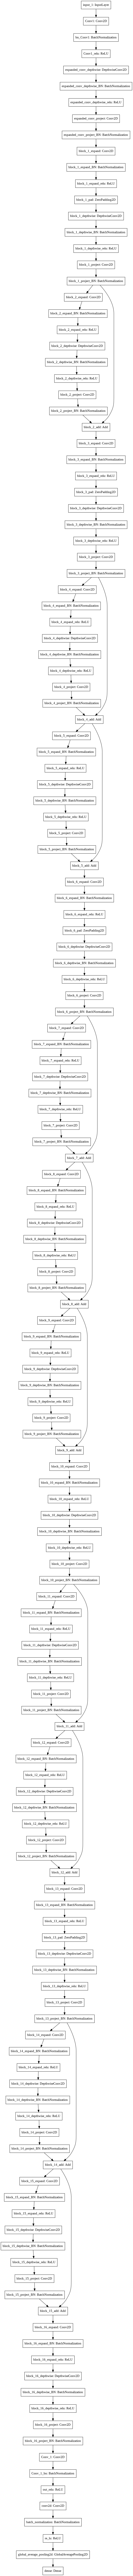

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [11]:
# Load pre-trained base model.
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False, weights='imagenet')
# Freeze the base model
base_model.trainable = False

# Add Custom layers
out_layer = tf.keras.layers.Conv2D(128, (1, 1), padding='SAME', activation=None)(base_model.output)
out_layer = tf.keras.layers.BatchNormalization()(out_layer)
out_layer = tf.keras.layers.ReLU()(out_layer) # 7x7x128

out_layer = tf.keras.layers.GlobalAveragePooling2D()(out_layer) # 128

out_layer = tf.keras.layers.Dense(2, activation='softmax')(out_layer)

# Make New Model
model = tf.keras.models.Model(base_model.input, out_layer)

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
____________________________________________________________________________________________

In [10]:
#<hisyory> 에러가 떠서 이것만 따로 해결 ing
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

#모델학습_Training (history에 Argument Error 있다.-연산이 잘못된 값이나 구조(shape)를 받는 경우 발생함.)
#Ver1
# history = model.fit(train_generator,
#                     steps_per_epoch = 100,
#                     epochs=25,
#                     batch_size=256,
#                     validation_data=validation_generator, 
#                     validation_steps=50,
#                     verbose=True)


val_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = val_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

#ver2
history = model.fit(train_generator, validation_data=validation_generator, epochs=25, verbose=True)

Found 37 images belonging to 2 classes.
Epoch 1/25
5/5 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 1.0000

ValueError: ignored

# 새 섹션